# K-means clustering

Como hemos visto, este es el primer algoritmo no supervisado que vamos a ver. Lo que esto significa es que vamos a darle una base datos a nuestro algoritmo y este agrupará los puntos en la base en el número de grupos que nosotros le digamos, buscando que sean lo más parecidos entre ellos posible.

Para cambiar un poco la dinámica, veamos una base de datos nueva. Vamos a utilizar la base de datos de sobrevivientes del Titanic (https://www.kaggle.com/c/titanic/data). Vamos a suponer que en realidad no conocemos sí es que X pasajero sobrevivió o no al hundimiento del barco, pero que tenemos una base de datos con características de los pasajeros que podrían darnos pistas sobre si dichos pasajeros pudieron o no abordar los botes salvavidas.

Todos sabemos (si no por leer por la película), que no existían botes salvavidas para todas las personas que iban en el barco; sabemos además, que a los botes suvieron primero mujeres y niños, así como personas de las clases sociales mejor acomodadas (el maldito clasismo que en este caso nos puede ayudar a identificar posibles sobrevivientes).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Descargamos las bases de datos de Kaggle
train_url = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv"
train = pd.read_csv(train_url)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_url = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv"
test = pd.read_csv(test_url)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# Descriptivitos básicos
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# Recordemos que en K-means, como en KNN, no podemos tener missing values, 
# porque lo que medimos son las distancias de los puntos en N dimensiones.
print(train.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
# Tenemos algunos NAs, en edad y otras dos variables que no son relevantes en este caso para lo que queremos hacer.
# Para no perder estas observaciones, podemos imputar a nuestra base los valores de estos missing values.
# En este caso vamos a ponerle la edad promedio, aunque podría ser la mediana u otro método más sofisticado.
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# Y checamos
print(train.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


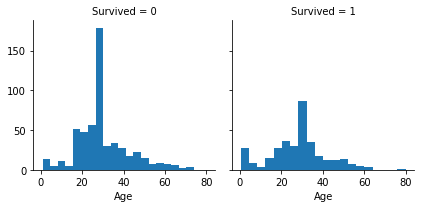

In [ ]:
# ¿Cómo se ve la edad de los que subrevivieron y los que no (ahorita que no hemos tirado la variable "survived")?
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

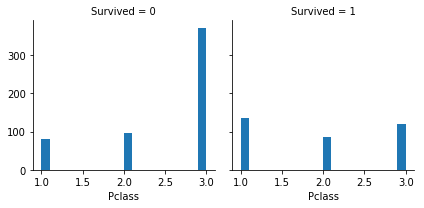

In [ ]:
# Y cómo se distribuyen por clase clase?
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Pclass', bins=20)

In [ ]:
# ERROR, por?
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [ ]:
# Sexo es caracter, convirtamos primero la variable de texto a numérico para que la grafique bien
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
labelEncoder.fit(train['Sex'])
labelEncoder.fit(test['Sex'])
train['Sex'] = labelEncoder.transform(train['Sex'])
test['Sex'] = labelEncoder.transform(test['Sex'])

list(labelEncoder.classes_)

ValueError: y contains previously unseen labels: 'male'

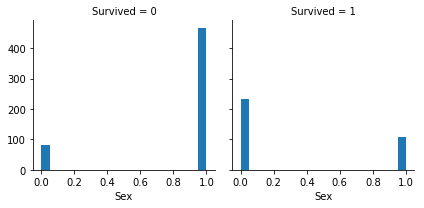

In [ ]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Sex', bins=20)

In [ ]:
# Quedémonos ahora sí con las variables que nos interesan de las bases
train = train.drop(['Name','Ticket', 'Cabin','Embarked'], axis=1)
test = test.drop(['Name','Ticket', 'Cabin','Embarked'], axis=1)

In [ ]:
# Vamos a separar la etiqueta (que suponemos que no existe ahorita) del resto de los datos que vamos a clusterear
X = train.drop(['Survived'], 1).astype(float)
X.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,1.0,3.0,1.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,0.0,38.0,1.0,0.0,71.2833
2,3.0,3.0,0.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,0.0,35.0,1.0,0.0,53.1000
4,5.0,3.0,1.0,35.0,0.0,0.0,8.0500


In [ ]:
y = train['Survived']
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [ ]:
# Ahoooora, antes de empezar a hacer algoritmos, recuerden que K-means mide distancias.
# Es importante entonces que reescalemos nuestras variables para que tengan una escala más o menos común
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Ahora sí
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2) # ¿Por qué le digo que quiero sólo 2 clusters/grupos?
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
# Vamos a evaluar cuantas pusimos en el cluster correcto (aprovechando que en este caso tenemos las etiquetas por ahí)
correct = 0
for i in range(len(X_scaled)):
    predict_me = np.array(X_scaled[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.2132435465768799


In [ ]:
### Ahora, qué hacemos si no tenemos los labels (que es justo por lo que usarías un algoritmo no supervisado)
# Podemos evaluar con un silhouette_score, que es una medida de qué tan bien definidos están nuestros clusters.
# En tre más alto sea, mejor definidos están, y por tanto mejor es nuestro clustering.
# Está basada en las distancias promedio de los puntos al punto medio, y la distancia entre puntos medios
from sklearn.metrics import silhouette_score

labels = kmeans.labels_
silhouette_score(X_scaled, labels, metric = 'euclidean')

0.43055447221341064

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=1000) # vamos a aumentarle el número de iteraciones que puede hacer a ver si mejora
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
labels = kmeans.labels_
silhouette_score(X_scaled, labels, metric = 'euclidean')

0.43055447221341064

In [ ]:
correct = 0
for i in range(len(X_scaled)):
    predict_me = np.array(X_scaled[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.7867564534231201


In [ ]:
# labels (numero del grupo al que pertenecen)
print(kmeans.labels_)

# centroides (comportamiento de la media del grupo)
print(kmeans.cluster_centers_)


[0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0
 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1
 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1
 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0
 0 0 1 0 1 1 0 0 0 0 0 0 

¿Por qué es tanta la diferencia de los que se clasificaron correctamente? aunque vemos que nuestro silhouette score sigue idéntico, por lo que no podemos decir que en realidad lo hicimos mucho mejor.